# Advanced Regression Techniques

A playground competition hosted by Kaggle to test advanced regression techniques. This notebook serves as a reference for how to approach and solve regression machine learning problems.

By Wong Tran <br>

<br>
<br>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import plotly.offline as pyo
import plotly.figure_factory as ff
import seaborn as sns

In [2]:
train_df = pd.read_csv("data/train.csv")
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-n

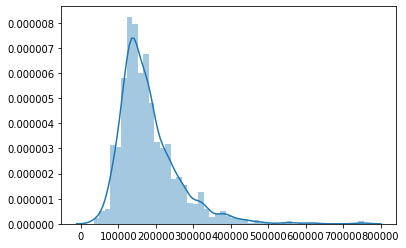

In [3]:
sns.distplot(train_df.SalePrice.values);

In [4]:
print("Skewness: %f" % train_df['SalePrice'].skew())
print("Kurtosis: %f" % train_df['SalePrice'].kurt())

Skewness: 1.882876
Kurtosis: 6.536282


In [5]:
train_df_reduced_feats = train_df[['OverallQual', 'YearBuilt', 'TotalBsmtSF', 'GrLivArea', 'SalePrice']]
numerical_feats = ['TotalBsmtSF', 'GrLivArea']
categorical_feats = ['OverallQual', 'YearBuilt']    

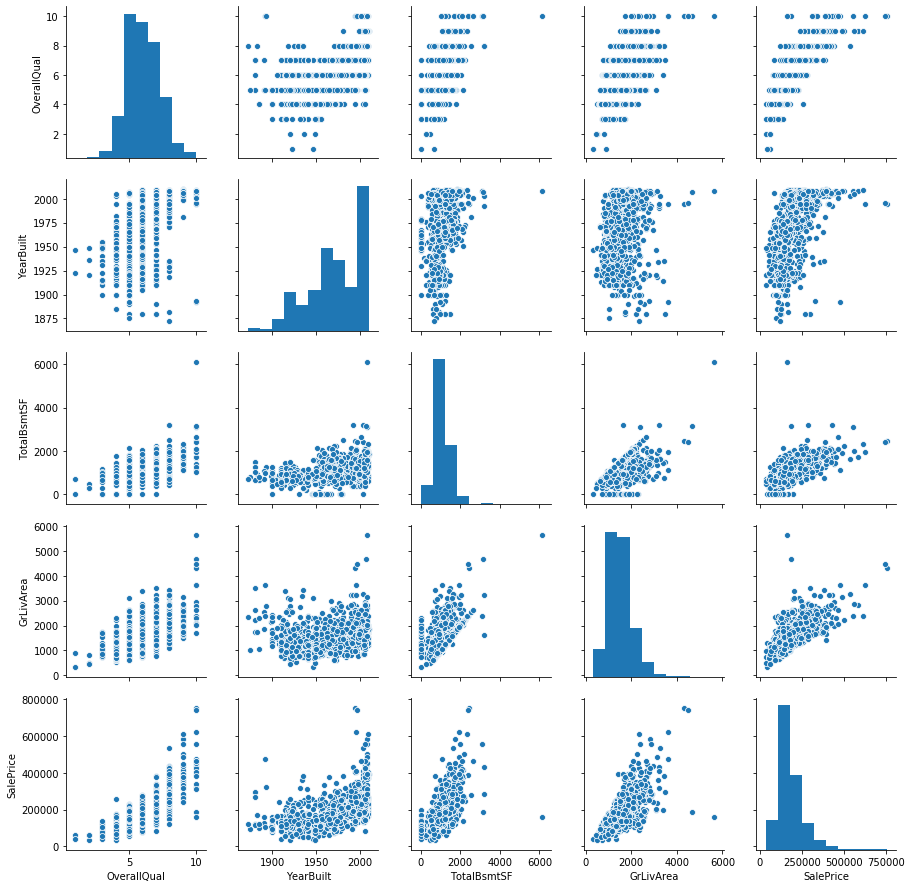

In [6]:
sns.pairplot(train_df_reduced_feats);

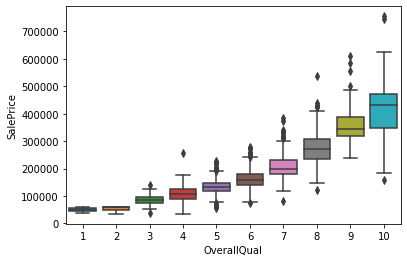

In [7]:
sns.boxplot('OverallQual', 'SalePrice', data=train_df_reduced_feats);

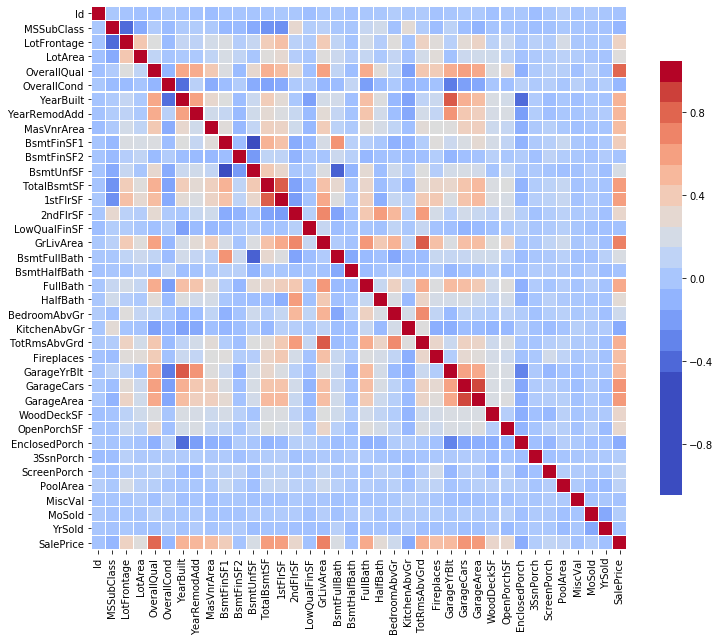

In [8]:
plt.figure(figsize=(12,10));
sns.heatmap(train_df.corr(), 
            cmap='coolwarm', 
            cbar_kws={'values':np.linspace(-1,1,21), 'shrink':0.8},
            #vmin=-1,
            linewidths=0.1
           )